In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect = True)
# reflect the tables

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

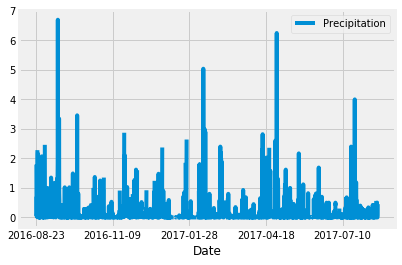

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastMonth = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

#year would be 365 but to match the data to the sample images we have to go back 366
#darn leap years
yearAgo = dt.datetime.strptime(lastMonth, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearAgo).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
dfYearAgo = pd.DataFrame(year, columns = ['Date', 'Precipitation'])
# Sort the dataframe by date
dfYearAgo.dropna()
dfYearAgo.set_index("Date", inplace = True)
dfYearAgo.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
dfYearAgo.plot()


In [181]:
dfYearAgo.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [117]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query(Station.id).count()
print(numStations)

9


In [123]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
numStationsSort = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

print(numStationsSort)

#most active station and count
print(numStationsSort[0])

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
('USC00519281', 2772)


In [110]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
topStationName = numStationsSort[0].station

topStation = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs))\
                           .filter(Measurement.station == topStationName).all()

print(topStation)

[(85.0, 54.0, 71.66378066378067)]


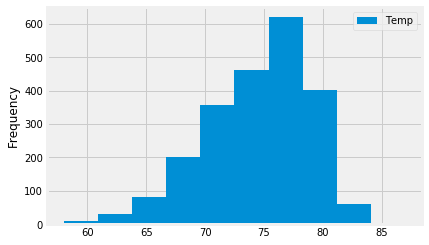

In [133]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationTemp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= yearAgo).all()

dfTopStationTemp = pd.DataFrame(stationTemp, columns = ['Date', 'Temp'])
# Sort the dataframe by date

dfTopStationTemp.dropna()
dfTopStationTemp.set_index("Date", inplace = True)
dfTopStationTemp.sort_index(inplace = True)

dfTopStationTemp.plot(kind = 'hist')


## Bonus Challenge Assignment

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [182]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#i guess im just picking an arbitrary start/end
tripBegin = '2016-08-01'
tripEnd = '2016-08-07'

#darn leap years again
tripYearAgoBegin = (dt.datetime.strptime(tripBegin, '%Y-%m-%d') - dt.timedelta(days = 366)).strftime('%Y-%m-%d')
tripYearAgoEnd = (dt.datetime.strptime(tripEnd, '%Y-%m-%d') - dt.timedelta(days = 366)).strftime('%Y-%m-%d')

print(calc_temps(tripYearAgoBegin, tripYearAgoEnd))


[(69.0, 78.27272727272727, 85.0)]


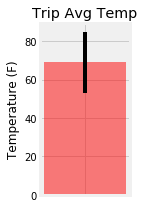

In [183]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)



temps = calc_temps(tripYearAgoBegin, tripYearAgoEnd)[0]

fig = plt.figure(figsize = (2, 3))
plt.bar(x = "", height = temps[0], yerr = temps[2] - temps[0], width = 0.05, alpha = 0.5, color = 'r')

plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [164]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
cols = [
        Station.station, 
        Station.name, 
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp)
        ]

rain = session.query(*cols).outerjoin(Station, Station.station == Measurement.station)\
                .group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(rain)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1068.0899999999956), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 588.6399999999976), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 382.61999999999847), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 295.67999999999944), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 234.49000000000026), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 131.62000000000063), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 92.68000000000006), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 70.87000000000005), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 43.44000000000002)]


In [167]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [193]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

#i could do this dynamically but im just being lazy
dates = ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

for date in dates:
    norm = daily_normals(date)[0]
    test = [norm[0], norm[1], norm[2]]
    normals.append(test)
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [196]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfNormal = pd.DataFrame(normals, columns = ['TMin', 'TAvg', 'TMax'], index = dates)
dfNormal.head(10)

,TMin,TAvg,TMax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


Text(0, 0.5, 'Temperature (F)')

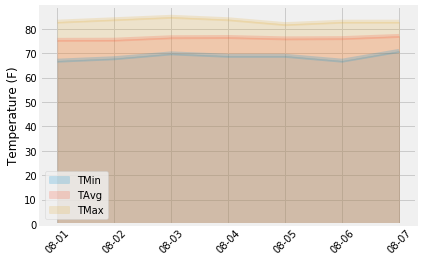

In [207]:
# Plot the daily normals as an area plot with `stacked=False`
ax = dfNormal.plot(kind = 'area', stacked = False, legend = True, alpha = 0.2, rot = 45 )

ax.set_ylabel('Temperature (F)')
